# Linearization of Differential Equations

Linearize the nonlinear differential equations and compare the linearized model simulation to the original nonlinear model response.

### Exercise 1 - Automobile

Linearize the momentum balance for the velocity of an automobile at steady state conditions when the gas pedal is maintained at 40%.

$$m\frac{dv(t)}{dt} = F_p u(t) - \frac{1}{2} \rho \, A \, C_d v(t)^2$$

with u(t) as gas pedal position (%pedal), v(t) as velocity (m/s), m as the mass of the vehicle (500 kg) plus the mass of the passengers and cargo (200 kg), Cd as the drag coefficient (0.24), $\rho$ as the air density (1.225 kg/m3), A as the vehicle cross-sectional area (5 m2), and Fp as the thrust parameter (30 N/%pedal). Simulate a step change in the gas pedal position, comparing the nonlinear response to the linear response. Comment on the accuracy of the linearized model.

In [1]:
# analytic solution
import sympy as sp
sp.init_printing()
# define symbols
v,u = sp.symbols(['v','u'])
Fp,rho,Cd,A,m = sp.symbols(['Fp','rho','Cd','A','m'])
# define equation
eqn = Fp*u/m - rho*A*Cd*v**2/(2*m)

print(sp.diff(eqn,v))
print(sp.diff(eqn,u))

-A*Cd*rho*v/m
Fp/m


In [2]:
# numeric solution
from scipy.misc import derivative
m = 700.0   # kg
Cd = 0.24
rho = 1.225 # kg/m^3
A = 5.0     # m^2
Fp = 30.0   # N/%pedal
u = 40.0    # % pedal
v = 50.0    # km/hr (change this for SS condition)
def fv(v):
    return Fp*u/m - rho*A*Cd*v**2/(2*m)
def fu(u):
    return Fp*u/m - rho*A*Cd*v**2/(2*m)

print('Approximate Partial Derivatives')
print(derivative(fv,v,dx=1e-4))
print(derivative(fu,u,dx=1e-4))

print('Exact Partial Derivatives')
print(-A*Cd*rho*v/m) # exact d(f(u,v))/dv
print(Fp/m) # exact d(f(u,v))/du

Approximate Partial Derivatives
-0.10500000000135401
0.04285714286011988
Exact Partial Derivatives
-0.105
0.04285714285714286


The differential equation in linear form becomes:

$$\frac{dv(t)}{dt} = \alpha \left(u(t) - 40\right) + \beta \left(v(t)-v_{ss}\right)$$

with the following definitions from the partial derivatives

$$\alpha = \frac{F_p}{m} = 0.042857$$

$$\beta = -\frac{A \, C_d \, \rho \, v_{ss}}{m} = constant$$

The steady state velocity is determined by setting the time derivative to zero, plugging in other steady state conditions, and solving for v_{ss}.

$$m\frac{dv(t)}{dt} = F_p u(t) - \frac{1}{2} \rho \, A \, C_d v(t)^2$$

$$0 = F_p u_{ss} - \frac{1}{2} \rho \, A \, C_d v_{ss}^2$$

$$v_{ss} = \sqrt{\frac{2 \, F_p u_{ss}}{\rho \, A \, C_d}}$$

$$v_{ss} = \sqrt{\frac{2 \times 30 \frac{N}{\%} \times 40 \%}{1.225 \frac{kg}{m^3} \times 5 m^2 \times 0.24}} = 40.406 \frac{m}{s}$$

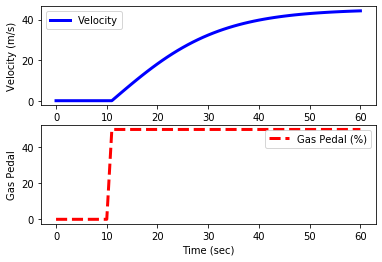

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# define model
def vehicle(v,t,u,load):
    # inputs
    #  v    = vehicle velocity (m/s)
    #  t    = time (sec)
    #  u    = gas pedal position (0% to 100%)
    #  load = passenger load + cargo (kg)
    Cd = 0.24    # drag coefficient
    rho = 1.225  # air density (kg/m^3)
    A = 5.0      # cross-sectional area (m^2)
    Fp = 30      # thrust parameter (N/%pedal)
    m = 500      # vehicle mass (kg)
    # calculate derivative of the velocity
    dv_dt = (1.0/(m+load)) * (Fp*u - 0.5*rho*Cd*A*v**2)
    return dv_dt

tf = 60.0                 # final time for simulation
nsteps = 61               # number of time steps
delta_t = tf/(nsteps-1)   # how long is each time step?
ts = np.linspace(0,tf,nsteps) # linearly spaced time vector

# simulate step test operation
step = np.zeros(nsteps) # u = valve % open
step[11:] = 50.0       # step up pedal position
# passenger(s) + cargo load
load = 200.0 # kg
# velocity initial condition
v0 = 0.0
# for storing the results
vs = np.zeros(nsteps)

# simulate with ODEINT
for i in range(nsteps-1):
    u = step[i]
    v = odeint(vehicle,v0,[0,delta_t],args=(u,load))
    v0 = v[-1]   # take the last value as initial condition
    vs[i+1] = v0 # store the velocity for plotting

# plot results
plt.figure()
plt.subplot(2,1,1)
plt.plot(ts,vs,'b-',linewidth=3)
plt.ylabel('Velocity (m/s)')
plt.legend(['Velocity'],loc=2)
plt.subplot(2,1,2)
plt.plot(ts,step,'r--',linewidth=3)
plt.ylabel('Gas Pedal')    
plt.legend(['Gas Pedal (%)'])
plt.xlabel('Time (sec)')
plt.show()

### Exercise 2 -Thermocouple

Linearize an energy balance that describes the temperature of a thermocouple bead $T_{t}$ given a change in the surrounding gas temperature $T_{g}$. Include the flame temperature $T_{f}$ as a variable in the linearization. Simulate a cyclical gas temperature change and a step change in flame temperature in both the linear and nonlinear versions of the model.

Some advanced combustion systems operate in a pulsed mode where an acoustic wave resonates in the combustor in order to enhance heat and mass transfer. The frequency of the wave is approximately 100Hz (cycles/sec). As a result, the temperature at any given spatial location in the combustor fluctuates with time. The fluctuations can be approximated as a sine wave with an amplitude of $75^oC$ for the system of interest. The objective is to measure the fluctuating temperature at a given point in the reactor with use of a thermocouple.

Heat is transferred to the thermocouple by convection and radiation. Heat transfer by radiation is approximated by $q = A \epsilon \sigma (T_f^4-T_t^4)$ where $A$ is the surface area, $\epsilon$ is the emissivity, and $\sigma$ is the Stefan-Boltzmann constant $(W/(m^2 K^4))$. The thermocouple bead is approximated as a sphere (e.g. ignore conduction along connecting wires).

Use the following values with subscript t as the thermocouple, subscript f as the flame, ss indicating steady-state, h as the heat transfer coefficient, cp as the heat capacity, $\rho$ as the density, and dt as the diameter of the thermocouple bead.

$$h=2800 \, \frac{W}{m^2 \, K} \quad \rho_{t} = 20 \, g/cm^3 \quad \sigma = 5.67e-8 \, \frac{W}{m^2\,K^4}$$
$$\epsilon=0.8 \quad T_{t,ss} = 1500 \, K \quad T_{f} = 1500 \, K$$
$$c_{p,t} = 0.4 \frac{J}{g\,K} \quad d_t = 0.01 \, cm$$

A starting Python script is available in the solution help. Add the linearized balance equation in addition to the nonlinear balance equation that is already implemented. Simulate both for the cycling gas temperature and discuss whether the linearized model is a suitable approximation of the nonlinear model. What changes could be made to the thermocouple to improve the ability to measure gas temperature?

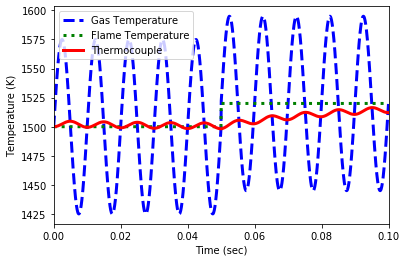

In [4]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# define thermocouple model
def thermocouple(x,t,Tg,Tf):
    ## States
    Tt = x[0]
    Tlin = x[1]

    ## Parameters
    h = 2800.0            # W/m^2-K
    rho = 20.0            # gm/cm^3
    sigma = 5.67e-8       # W/m^2-K^4
    eps = 0.8             #
    Cp = 0.4              # J/gm-K    
    d = 0.01              # cm
    r = d / 2.0           # radius
    A = 4.0 * np.pi * (r/100.0)**2 # sphere area (m^2)
    V = 4.0/3.0 * np.pi * r**3 # sphere volume (cm^3)

    # acc = inlet - outlet
    # acc = m * Cp * dT/dt = rho * V * Cp * dT/dt
    # inlet - outlet from 2 heat transfer pathways
    # q(convection) = h * A * (Tg-Tt)
    # q(radiation) = A * esp * sigma * (Tf^4 - Tt^4)
    q_conv = h * A * (Tg-Tt)
    q_rad = A * eps * sigma * (Tf**4 - Tt**4)
    dTdt = (q_conv + q_rad) / (rho * V * Cp)
    dTlin_dt = 0.0 # add linearized equation
    return [dTdt,dTlin_dt]

# Flame temperature
Tf0 = 1500.0 #K

# Starting thermocouple temperature
y0 = [Tf0,Tf0]

# Time Intervals (sec)
t = np.linspace(0,0.1,1000)

# Flame Temperature
Tf = np.ones(len(t))*Tf0
Tf[500:] = 1520.0 #K

# Gas temperature cycles
Tg = Tf + (150.0/2.0) * np.sin(2.0 * np.pi * 100.0 * t) #K

# Store thermocouple temperature for plotting
Tt = np.ones(len(t)) * Tf
Tlin = np.ones(len(t)) * Tf

for i in range(len(t)-1):
    ts = [t[i],t[i+1]]
    y = odeint(thermocouple,y0,ts,args=(Tg[i],Tf[i]))
    y0 = y[-1]
    Tt[i+1] = y0[0]
    Tlin[i+1] = y0[1]

# Plot the results
plt.figure()
plt.plot(t,Tg,'b--',linewidth=3,label='Gas Temperature')
plt.plot(t,Tf,'g:',linewidth=3,label='Flame Temperature')
plt.plot(t,Tt,'r-',linewidth=3,label='Thermocouple')
plt.ylabel('Temperature (K)')
plt.legend(loc='best')
plt.xlim([0,t[-1]])
plt.xlabel('Time (sec)')

plt.show()